In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
# df['LOCAL_DATE'] = pd.to_datetime(df['LOCAL_DATE'])
# df.set_index('LOCAL_DATE', inplace=True)

# columns_to_plot = df.iloc[:, :]

# # Loop through each selected column and plot it
# for column in columns_to_plot.columns:
#     if pd.api.types.is_numeric_dtype(columns_to_plot[column]):
#         plt.figure(figsize=(10, 5))  # Set the figure size
#         plt.plot(df.index, columns_to_plot[column], marker='.')  # Plot each column as a line graph
#         plt.title(f'Line Graph for {column}')  # Title with the column name
#         plt.xlabel('Date')  # Label for the x-axis
#         plt.ylabel(column)  # Label for the y-axis
#         plt.grid(True)  # Add a grid for better readability
#         plt.show()  # Display the plot
#     else:
#         print(f"Skipping column {column} as it is not numeric.")

In [3]:
df = pd.read_csv('Data/collective1972-2023.csv')

# Extract year, month, and day into separate columns
df['LOCAL_DATE'] = pd.to_datetime(df['LOCAL_DATE'])
df['Month'] = df['LOCAL_DATE'].dt.month
df = pd.get_dummies(df, columns=['Month'])


# Drop any non-numeric columns that aren't needed for training
df.drop(['LOCAL_DATE', 'SYM', 'CITY', 'STATION', 'LATITUDE', 'LONGITUDE', 'LATITUDE', 'MAX_REL_HUMIDITY', 'MIN_REL_HUMIDITY', 'DIRECTION_MAX_GUST', 
         'SPEED_MAX_GUST', 'COOLING_DEGREE_DAYS', 'TOTAL_RAIN', 'TOTAL_SNOW', 'Flow-1','Flow-2', 'Flow-3'], axis=1, inplace=True)

# Create new columns with flow values after 1 day, 2 days, 3 days
df['Flow+1'] = df['Flow0'].shift(-1)  # Shift up by 1
df['Flow+2'] = df['Flow0'].shift(-2)  # Shift up by 2
df['Flow+3'] = df['Flow0'].shift(-3)  # Shift up by 3

# Impute missing values
# imputer = SimpleImputer(strategy='constant', fill_value=0)
# df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df_imputed = df.dropna()

print(df_imputed.describe())
# Define X and Y
Y = df_imputed[['Flow0', 'Flow+1', 'Flow+2', 'Flow+3']]  # Target variable
X = df_imputed.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features

FileNotFoundError: [Errno 2] No such file or directory: 'collective1972-2023.csv'

In [ ]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
# Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1)).flatten()
Y_scaled = scaler_Y.fit_transform(Y)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.30, random_state=3)


In [ ]:

# Train the SVR model
# 'C': 100, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'
svr_linear = SVR(kernel='linear')
multi_svr_linear = MultiOutputRegressor(svr_linear)
multi_svr_linear.fit(X_train, Y_train)

# Y_pred = svm_model.predict(X_test)

# Make predictions
Y_pred_scaled = multi_svr_linear.predict(X_test)
# Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_pred = np.maximum(Y_pred, 0)

Y_test = scaler_Y.inverse_transform(Y_test)



In [ ]:
# from sklearn.inspection import permutation_importance

# svr_linear = SVR(kernel='linear')
# multi_svr_linear = MultiOutputRegressor(svr_linear)
# multi_svr_linear.fit(X_train, Y_train)


# # Calculate permutation importance
# results = permutation_importance(multi_svr_linear, X_test, Y_test, scoring='neg_mean_squared_error', n_repeats=10, random_state=0)



In [ ]:


# # Feature names
# features = ['HEATING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'TOTAL_RAIN', 'TOTAL_SNOW', 'SNOW_ON_GROUND', 
#              'MAX_TEMPERATURE', 'MEAN_TEMPERATURE', 'MIN_TEMPERATURE', 'Flow-1', 'Flow-2', 'Flow-3']

# # Create DataFrame for results
# importance_df = pd.DataFrame({
#     'Feature': features,
#     'Importance': np.mean(results.importances, axis=1)
# })

# # # Make predictions
# # Y_pred_scaled = multi_svr_linear.predict(X_test)
# # Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
# # Y_pred = np.maximum(Y_pred, 0)
# # Y_test = scaler_Y.inverse_transform(Y_test)

# # Set the style
# sns.set(style="whitegrid")

# # Plot
# plt.figure(figsize=(12, 8))
# sns.barplot(x='Feature', y='Importance', data=importance_df, palette='viridis')
# plt.title('Feature Importance for SVR Model (Permutation Importance)')
# plt.xlabel('Feature')
# plt.ylabel('Importance')
# plt.xticks(rotation=45, ha='right')
# plt.show()


In [ ]:

# # Define the parameter grid
# param_grid = {
#     'kernel': ['linear'],
#     'C': [1, 10, 100, 1000],
#     'gamma': [0.01, 0.1, 1],
#     # 'epsilon': [0.01, 0.1, 1],
#     # 'degree': [2, 3, 4]  # Only for polynomial kernel
# }

# # Perform grid search
# grid_search = GridSearchCV(SVR(), param_grid, refit=True, verbose=3, cv=2)
# grid_search.fit(X_train, Y_train)

# # Make predictions
# Y_pred_scaled = grid_search.predict(X_test)
# Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()
# Y_pred = np.maximum(Y_pred, 0)

# Y_test = scaler_Y.inverse_transform(Y_test.reshape(-1, 1)).flatten()

# # Best parameters and score
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best score: {grid_search.best_score_}")

# # Predict with best estimator
# best_svr = grid_search.best_estimator_
# Y_pred = best_svr.predict(X_test)


In [ ]:
# Assuming Y_test has multiple columns corresponding to different flows (e.g., Flow+1, Flow+2, Flow+3)

# Flow +0 Day -----------------------------------------------
mse = mean_squared_error(Y_test[:, 0], Y_pred[:, 0])
print(f"Mean Squared Error (Flow +1): {mse}")

r_squared = r2_score(Y_test[:, 0], Y_pred[:, 0])
print(f"R-squared (Flow +1): {r_squared}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (Flow +1): {rmse}\n")

# Flow +1 Days -----------------------------------------------
mse = mean_squared_error(Y_test[:, 1], Y_pred[:, 1])
print(f"Mean Squared Error (Flow +2): {mse}")

r_squared = r2_score(Y_test[:, 1], Y_pred[:, 1])
print(f"R-squared (Flow +2): {r_squared}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (Flow +2): {rmse}\n")

# Flow +2 Days -----------------------------------------------
mse = mean_squared_error(Y_test[:, 2], Y_pred[:, 2])
print(f"Mean Squared Error (Flow +3): {mse}")

r_squared = r2_score(Y_test[:, 2], Y_pred[:, 2])
print(f"R-squared (Flow +3): {r_squared}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (Flow +3): {rmse}\n")

# Flow +3 Days -----------------------------------------------
mse = mean_squared_error(Y_test[:, 3], Y_pred[:, 3])
print(f"Mean Squared Error (Flow +3): {mse}")

r_squared = r2_score(Y_test[:, 3], Y_pred[:, 3])
print(f"R-squared (Flow +3): {r_squared}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (Flow +3): {rmse}\n")

Mean Squared Error (Flow +1): 10461.918001689884
R-squared (Flow +1): 0.9795746475157165
Root Mean Squared Error (Flow +1): 102.28351774205795

Mean Squared Error (Flow +2): 18816.72787535759
R-squared (Flow +2): 0.9633054192250406
Root Mean Squared Error (Flow +2): 137.17407872975707

Mean Squared Error (Flow +3): 32523.870197607444
R-squared (Flow +3): 0.936821647348353
Root Mean Squared Error (Flow +3): 180.3437556379689

Mean Squared Error (Flow +3): 36616.349666464324
R-squared (Flow +3): 0.9286829610036711
Root Mean Squared Error (Flow +3): 191.35399046391566



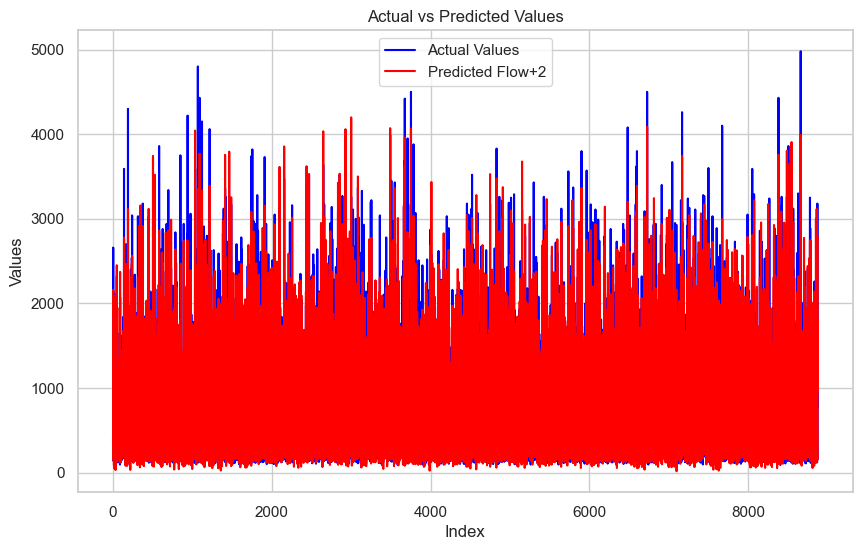

In [ ]:
plt.figure(figsize=(10, 6))
# plt.plot(range(len(Y_test)), Y_test[:, 0], color='black', label='Actual Values')
# plt.plot(range(len(Y_test)), Y_test[:, 1], color='black', label='Actual Values')
plt.plot(range(len(Y_test)), Y_test[:, 2], color='blue', label='Actual Values')
# plt.plot(range(len(Y_test)), Y_test[:, 3], color='blue', label='Actual Values')
# plt.plot(range(len(Y_pred)), Y_pred[:, 0], color='red', label='Predicted Flow+0')
# plt.plot(range(len(Y_pred)), Y_pred[:, 1], color='blue', label='Predicted Flow+1')
plt.plot(range(len(Y_pred)), Y_pred[:, 2], color='red', label='Predicted Flow+2')
# plt.plot(range(len(Y_pred)), Y_pred[:, 3], color='red', label='Predicted Flow+3')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

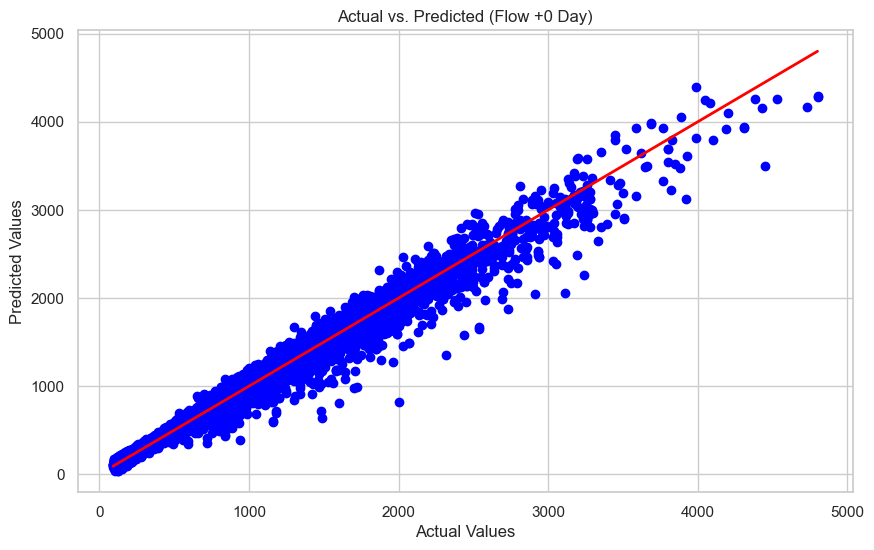

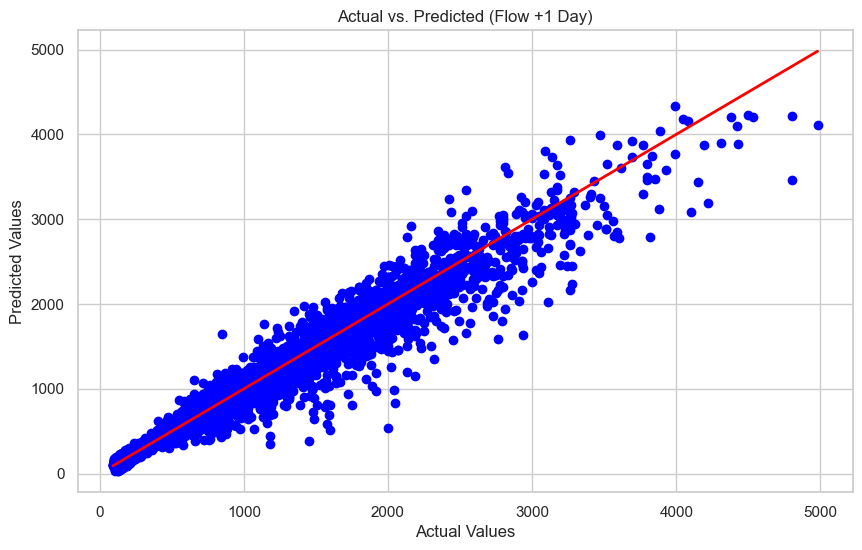

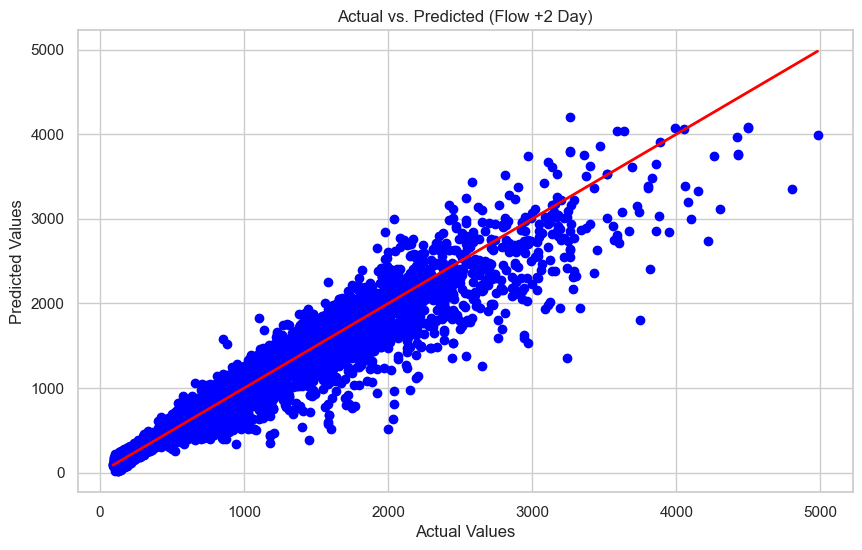

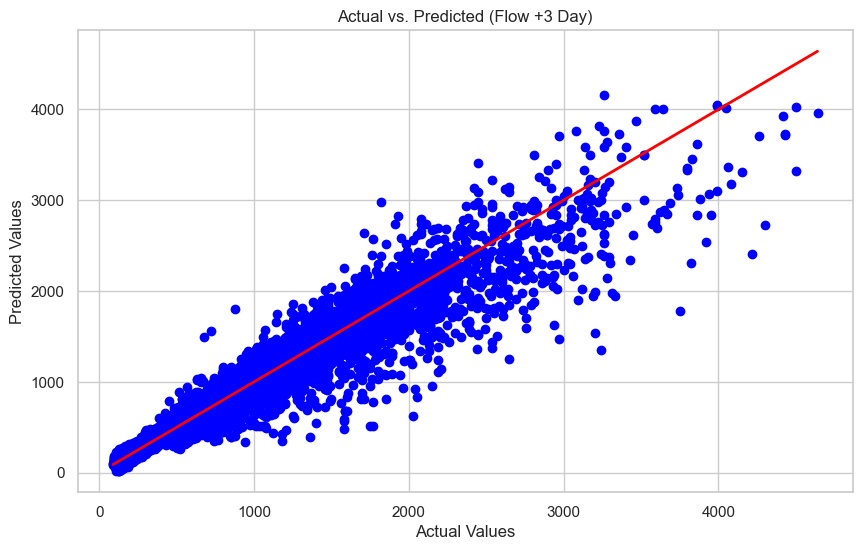

In [ ]:
# Scatter plots for each output (Flow+1, Flow+2, Flow+3)
for i in range(Y_pred.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.scatter(Y_test[:, i], Y_pred[:, i], color='blue')
    plt.plot([min(Y_test[:, i]), max(Y_test[:, i])], [min(Y_test[:, i]), max(Y_test[:, i])], color='red', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted (Flow +{i} Day)')
    plt.show()


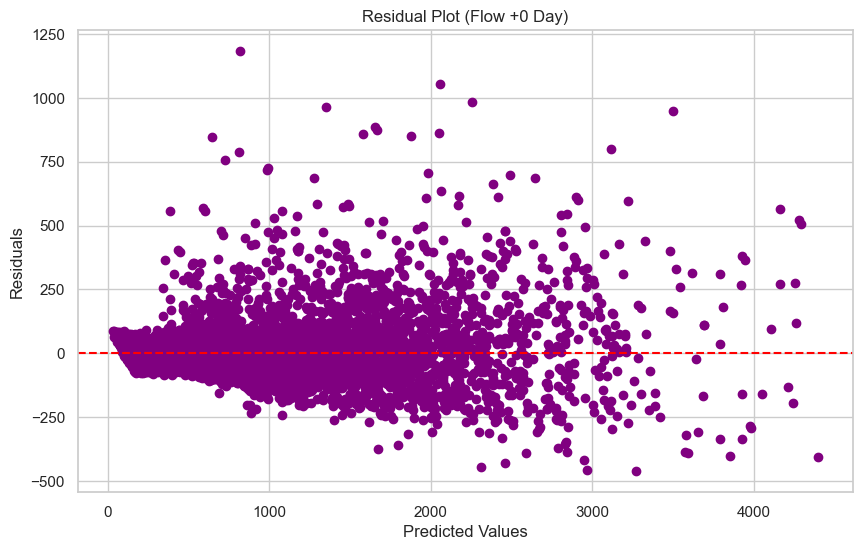

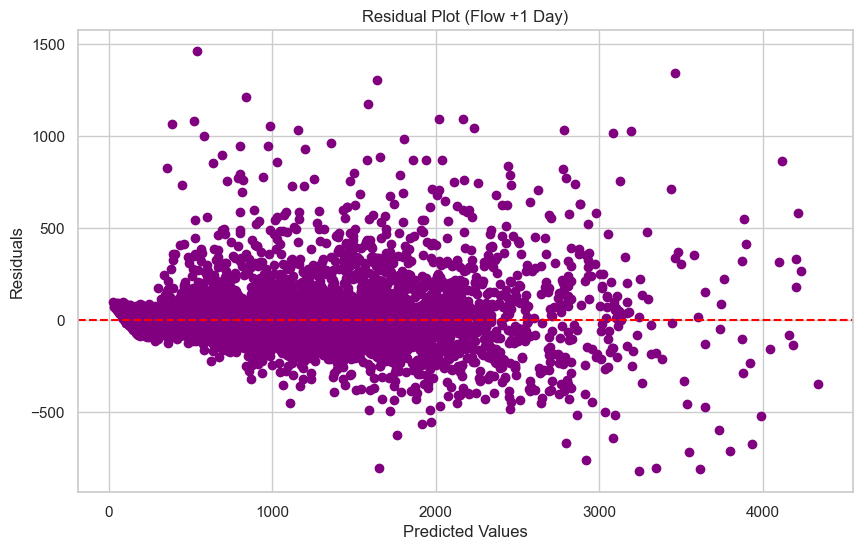

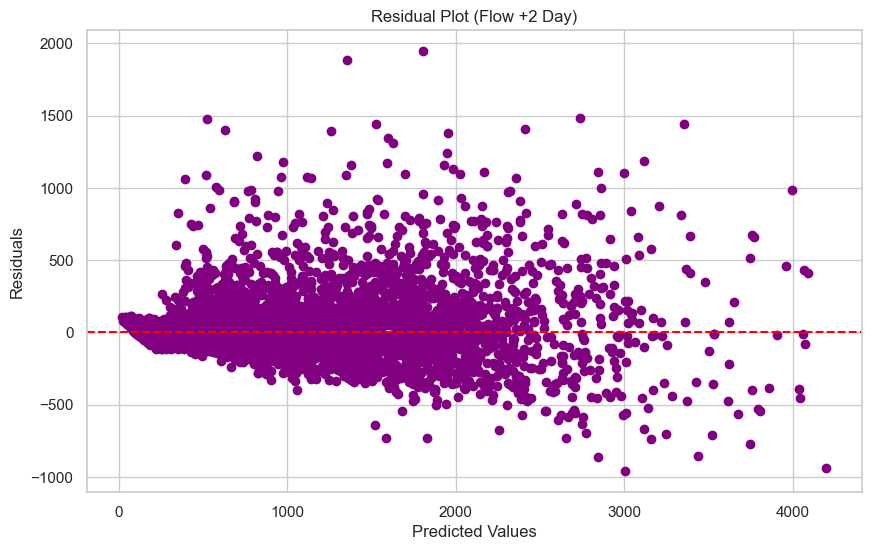

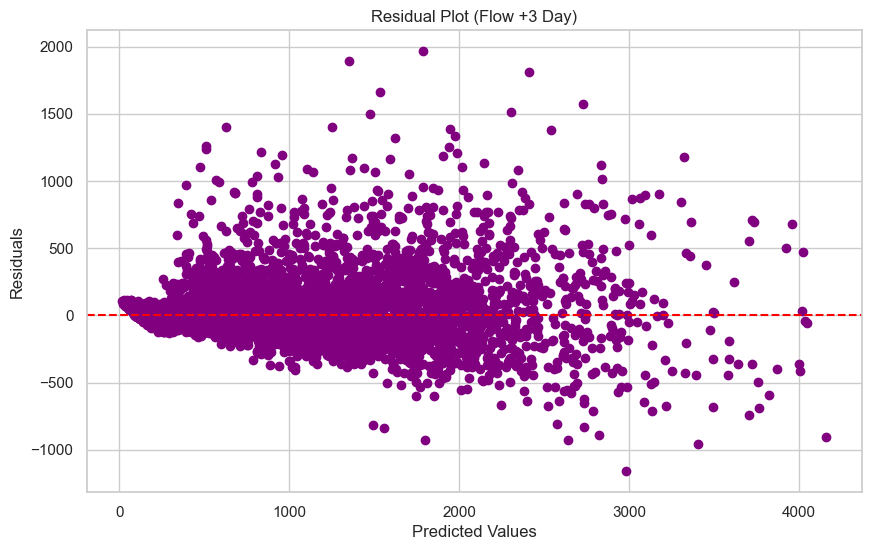

In [ ]:
# Residual plots for each output (Flow+1, Flow+2, Flow+3)
for i in range(Y_pred.shape[1]):
    residuals = Y_test[:, i] - Y_pred[:, i]

    plt.figure(figsize=(10, 6))
    plt.scatter(Y_pred[:, i], residuals, color='purple')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot (Flow +{i} Day)')
    plt.show()


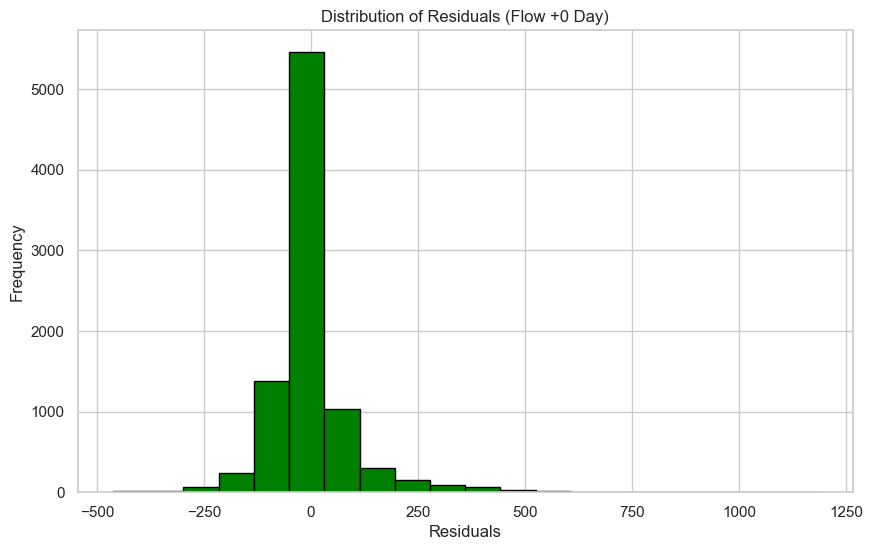

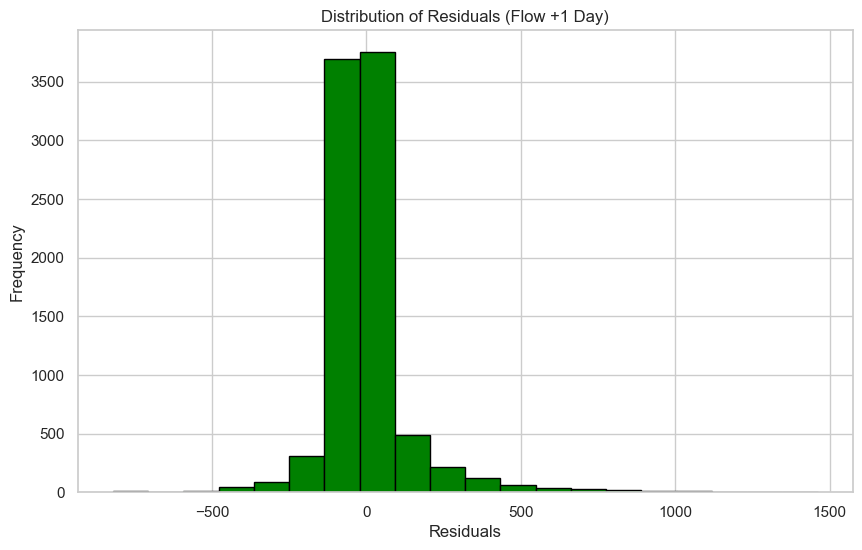

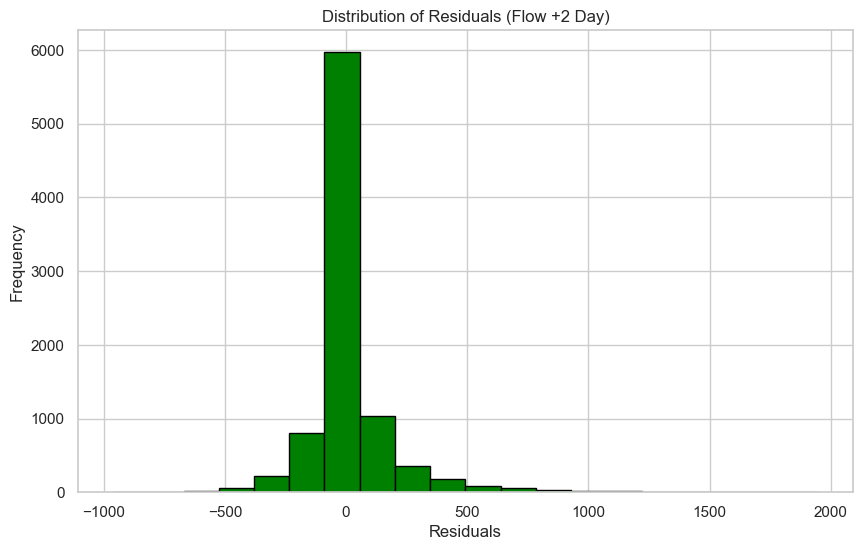

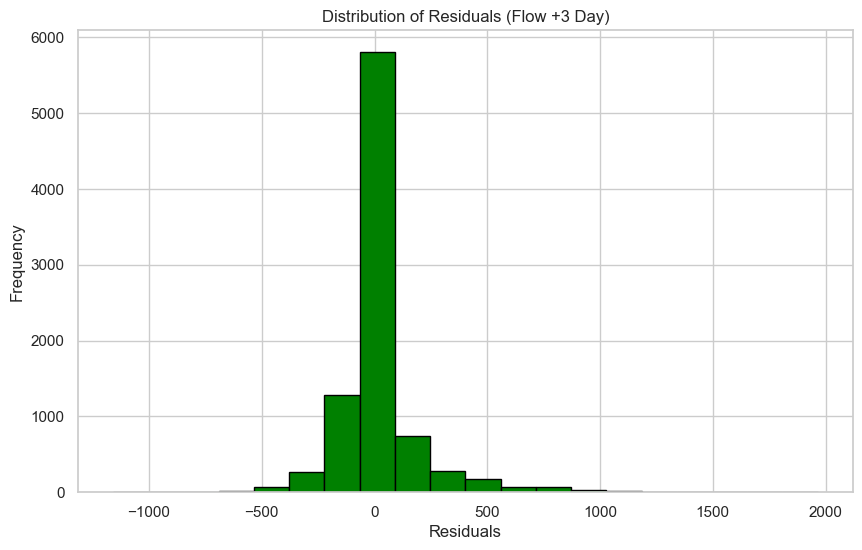

In [ ]:
# Histogram of residuals for each output (Flow+1, Flow+2, Flow+3)
for i in range(Y_pred.shape[1]):
    residuals = Y_test[:, i] - Y_pred[:, i]

    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=20, color='green', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Residuals (Flow +{i} Day)')
    plt.show()


In [ ]:
# new_data = pd.read_csv('Data/liard1944-2013.csv')  # Replace with the actual path to your new dataset

# new_data['LOCAL_DATE'] = pd.to_datetime(new_data['LOCAL_DATE'])
# new_data.set_index('LOCAL_DATE', inplace=True)

# columns_to_plot = new_data.iloc[:, :]

# # Loop through each selected column and plot it
# for column in columns_to_plot.columns:
#     if pd.api.types.is_numeric_dtype(columns_to_plot[column]):
#         plt.figure(figsize=(10, 5))  # Set the figure size
#         plt.plot(new_data.index, columns_to_plot[column], marker='.')  # Plot each column as a line graph
#         plt.title(f'Line Graph for {column}')  # Title with the column name
#         plt.xlabel('Date')  # Label for the x-axis
#         plt.ylabel(column)  # Label for the y-axis
#         plt.grid(True)  # Add a grid for better readability
#         plt.show()  # Display the plot
#     else:
#         print(f"Skipping column {column} as it is not numeric.")

In [ ]:
new_data = pd.read_csv('Data/liard1944-2013.csv')  # Replace with the actual path to your new dataset

# Extract year, month, and day into separate columns
new_data['LOCAL_DATE'] = pd.to_datetime(new_data['LOCAL_DATE'])
new_data['Month'] = new_data['LOCAL_DATE'].dt.month
new_data = pd.get_dummies(new_data, columns=['Month'])


# Drop any non-numeric columns that aren't needed for training
new_data.drop(['LOCAL_DATE', 'SYM', 'CITY', 'STATION', 'LATITUDE', 'LONGITUDE', 'LATITUDE', 'MAX_REL_HUMIDITY', 'MIN_REL_HUMIDITY',
                'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST', 'COOLING_DEGREE_DAYS', 'TOTAL_RAIN', 'TOTAL_SNOW', 'Flow-1', 'Flow-2', 'Flow-3'], axis=1, inplace=True)

# Create new columns with flow values after 1 day, 2 days, 3 days
new_data['Flow+1'] = new_data['Flow0'].shift(-1)  # Shift up by 1
new_data['Flow+2'] = new_data['Flow0'].shift(-2)  # Shift up by 2
new_data['Flow+3'] = new_data['Flow0'].shift(-3)  # Shift up by 3

# Impute missing values
# imputer = SimpleImputer(strategy='constant', fill_value=0)
# new_data_imputed = pd.DataFrame(imputer.fit_transform(new_data), columns=new_data.columns)
new_data_imputed = new_data.dropna()

# selected_data = new_data_imputed.iloc[420:430]

# new_data_imputed.drop(new_data_imputed.index[4000:6000], inplace=True)

print(new_data_imputed.describe())
print(new_data_imputed.head(4))
# Define X and Y
Y2 = new_data_imputed[['Flow0', 'Flow+1', 'Flow+2', 'Flow+3']]  # Target variable
X2 = new_data_imputed.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features

       HEATING_DEGREE_DAYS  TOTAL_PRECIPITATION  SNOW_ON_GROUND  \
count         19890.000000         19890.000000    19890.000000   
mean             20.280890             1.151262       21.075163   
std              15.082349             2.780630       26.769050   
min               0.000000             0.000000        0.000000   
25%               7.500000             0.000000        0.000000   
50%              16.500000             0.000000        2.000000   
75%              31.900000             1.000000       42.000000   
max              68.600000            47.000000      122.000000   

       MAX_TEMPERATURE  MEAN_TEMPERATURE  MIN_TEMPERATURE         Flow0  \
count     19890.000000      19890.000000     19890.000000  19890.000000   
mean          3.616511         -2.242428        -8.104932   1179.295173   
std          15.474088         15.137374        15.163554   1247.041922   
min         -47.900000        -50.600000       -56.200000    125.000000   
25%          -8.00000

In [ ]:
scaler_X2 = StandardScaler()
scaler_Y2 = StandardScaler()

X_scaled2 = scaler_X2.fit_transform(X2)
# Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1)).flatten()
Y_scaled2 = scaler_Y2.fit_transform(Y2)

Y_pred_scaled2 = multi_svr_linear.predict(X_scaled2)
# Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()
Y_pred2 = scaler_Y2.inverse_transform(Y_pred_scaled2)
Y_pred2 = np.maximum(Y_pred2, 0)

# Example: Viewing predictions
print(Y_pred2)



[[ 411.22929017  462.86084407  584.92481162  624.4932195 ]
 [ 405.57040276  455.47243147  574.30961398  614.08704612]
 [ 402.02405964  451.63565386  569.2127239   609.17281953]
 ...
 [3885.62617743 3856.49820962 3776.55504019 3763.01889441]
 [3851.00024037 3824.83949678 3747.85797335 3735.997943  ]
 [3594.37667668 3559.48520215 3457.48564016 3429.250675  ]]


In [ ]:
# Flow 0 Day -----------------------------------------------
mse = mean_squared_error(Y2.iloc[:, 0], Y_pred2[:, 0])
print(f"Mean Squared Error (Flow +1): {mse}")

r_squared = r2_score(Y2.iloc[:, 0], Y_pred2[:, 0])
print(f"R-squared (Flow +1): {r_squared}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (Flow +1): {rmse}\n")

# Flow +1 Days -----------------------------------------------
mse = mean_squared_error(Y2.iloc[:, 1], Y_pred2[:, 1])
print(f"Mean Squared Error (Flow +2): {mse}")

r_squared = r2_score(Y2.iloc[:, 1], Y_pred2[:, 1])
print(f"R-squared (Flow +2): {r_squared}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (Flow +2): {rmse}\n")

# Flow +2 Days -----------------------------------------------
mse = mean_squared_error(Y2.iloc[:, 2], Y_pred2[:, 2])
print(f"Mean Squared Error (Flow +3): {mse}")

r_squared = r2_score(Y2.iloc[:, 2], Y_pred2[:, 2])
print(f"R-squared (Flow +3): {r_squared}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (Flow +3): {rmse}\n")

# Flow +3 Days -----------------------------------------------
mse = mean_squared_error(Y2.iloc[:, 3], Y_pred2[:, 3])
print(f"Mean Squared Error (Flow +3): {mse}")

r_squared = r2_score(Y2.iloc[:, 3], Y_pred2[:, 3])
print(f"R-squared (Flow +3): {r_squared}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (Flow +3): {rmse}\n")


Mean Squared Error (Flow +1): 18080.876771406023
R-squared (Flow +1): 0.9883726909778627
Root Mean Squared Error (Flow +1): 134.46515076928304

Mean Squared Error (Flow +2): 51125.384410744744
R-squared (Flow +2): 0.9671261343066393
Root Mean Squared Error (Flow +2): 226.1092311488957

Mean Squared Error (Flow +3): 90063.76953141444
R-squared (Flow +3): 0.942087248280404
Root Mean Squared Error (Flow +3): 300.1062637323894

Mean Squared Error (Flow +3): 126828.34841708509
R-squared (Flow +3): 0.9184389208539784
Root Mean Squared Error (Flow +3): 356.12967921402605



In [ ]:
# Define the range of indices you want to plot
start_index = 420
end_index = 430


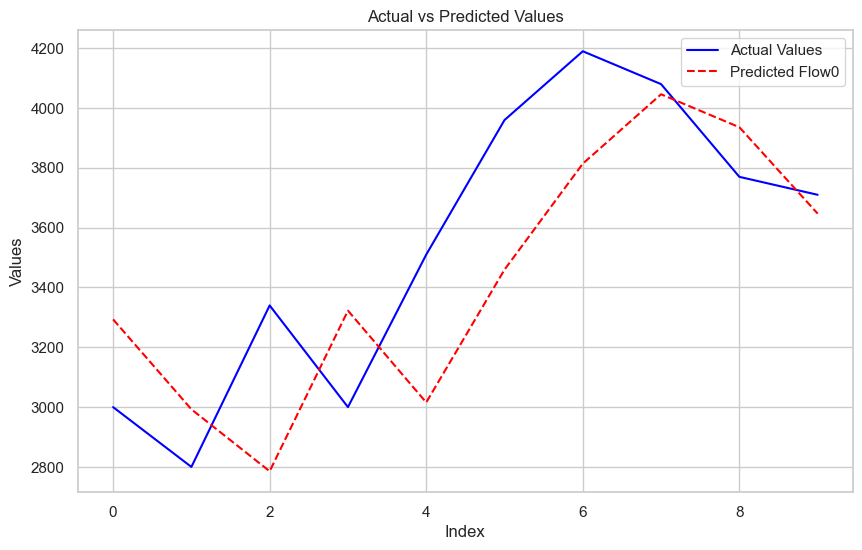

In [ ]:

# Ensure indices are within bounds
start_index = max(start_index, 0)
end_index = min(end_index, len(Y2))

# Slice the arrays
Y2_subset = Y2.iloc[start_index:end_index]
Y_pred2_subset = Y_pred2[start_index:end_index]

plt.figure(figsize=(10, 6))
plt.plot(range(len(Y2_subset)), Y2_subset.iloc[:, 0], color='blue', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset.iloc[:, 1], color='blue', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset.iloc[:, 2], color='blue', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset.iloc[:, 3], color='blue', label='Actual Values')
plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 0], color='red', linestyle='--', label='Predicted Flow0')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 1], color='red', label='Predicted Flow+1')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 2], color='red', label='Predicted Flow+2')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 3], color='red', label='Predicted Flow+3')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

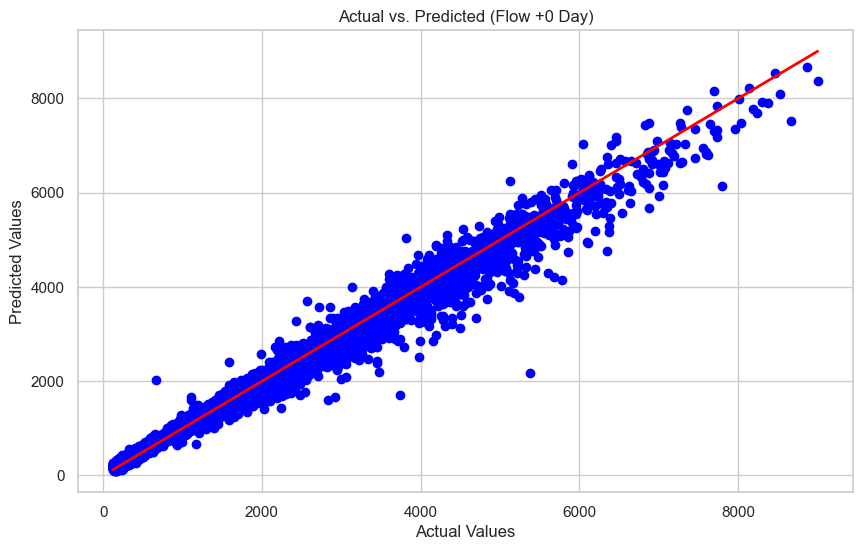

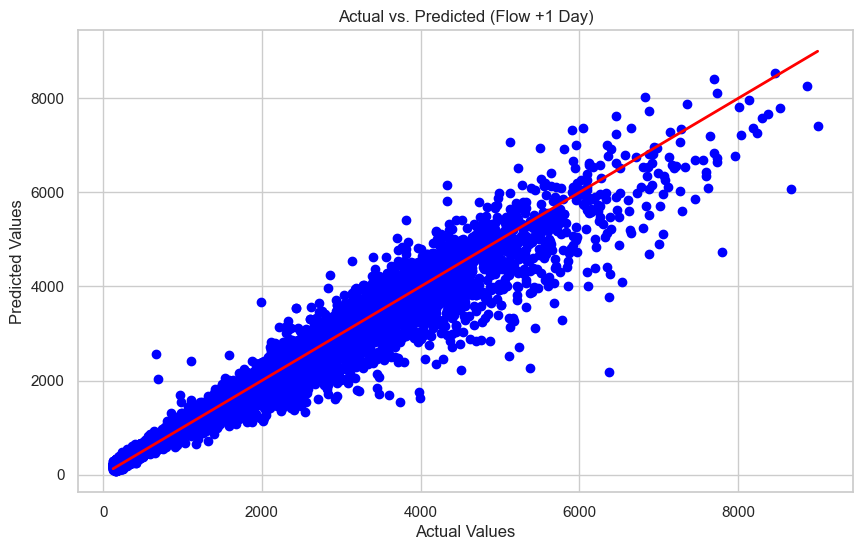

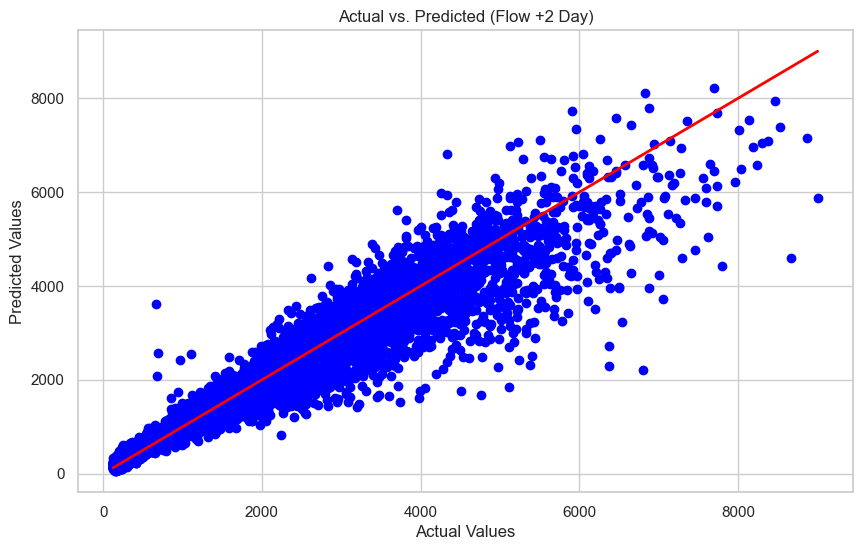

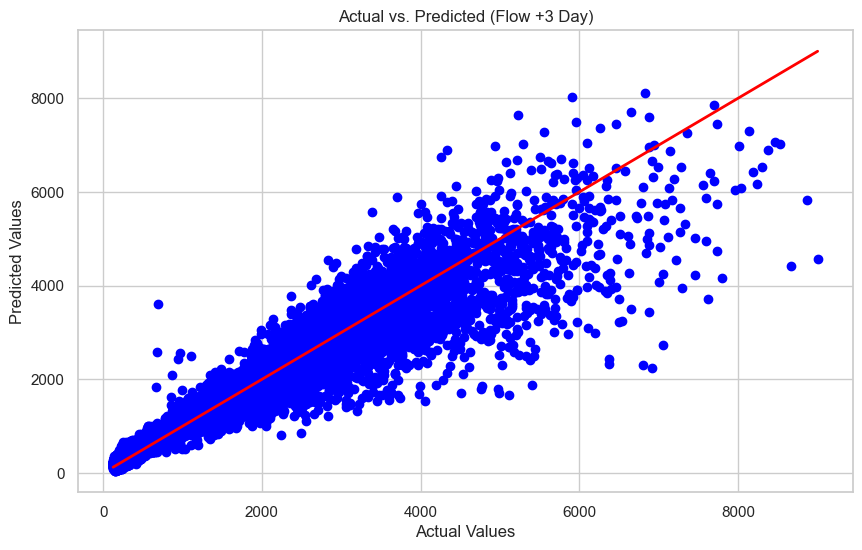

In [ ]:
# Scatter plots for each output (Flow+1, Flow+2, Flow+3)
for i in range(Y_pred2.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.scatter(Y2.iloc[:, i], Y_pred2[:, i], color='blue')
    plt.plot([min(Y2.iloc[:, i]), max(Y2.iloc[:, i])], [min(Y2.iloc[:, i]), max(Y2.iloc[:, i])], color='red', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted (Flow +{i} Day)')
    plt.show()
